## CAPM Simulation_Jegadeesh et al. (2018) 

In [1]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [2]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
from datetime import datetime
import linearmodels

In [3]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [4]:
ols_model = LinearRegression()

In [5]:
## Newey-West Adjustment 
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

In [6]:
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

## Import the simulation parameters from Jegadeesh et al. (2018)

In [7]:
# Import MKT  
mean_MKT = 5.80/100/252
sd_MKT = 15.33/100/np.sqrt(252)
print(mean_MKT, sd_MKT)

0.00023015873015873014 0.009656992285385755


In [8]:
# Import betas
m_all_betas = 0.95
sd_all_betas = 0.42
print(m_all_betas, sd_all_betas)

0.95 0.42


In [9]:
# Import residual sigmas
m_all_sigmas = 58.73/100/252
sd_all_sigmas = 23.81/100/np.sqrt(252)
print(m_all_sigmas, sd_all_sigmas)

0.0023305555555555553 0.014998890170582832


## beta,i and res_sigma,i are fixed through 100 repetitions

In [10]:
# How many stocks in the simulation sample on cross-section
N = 2000

In [11]:
# How many days in the simulation sample on time-series
T = 684*21

In [12]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
print(np.mean(sim_betas_tmp), np.std(sim_betas_tmp))

0.9397845700952917 0.4140429814104117


In [13]:
## ** the betas and sigma(i,resids) are generated at the begining of each simulation and keep them constant
## across 1000 repetitions 
sim_betas = pd.DataFrame(sim_betas_tmp)
# sim_betas = sim_betas.iloc[sim_betas.index.repeat(len(df_Ex_SR)),:]
# sim_betas = sim_betas.reset_index(drop = True)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.961044,1.915461,2.226934,0.360811,1.073412,1.514446,0.782555,0.612847,1.081794,0.994944,...,0.820436,1.582653,1.094354,0.753687,1.228797,1.066853,1.641464,1.795579,0.985102,1.228943


In [14]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.0023131336989431974, 0.014438793653725726)

In [15]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.001725,0.021937,0.007326,0.019947,0.006676,0.010572,0.005777,0.016209,0.005689,0.007965,...,0.000178,0.008931,0.009833,0.030002,0.019387,0.022843,0.024021,0.003315,0.005594,0.009934


In [16]:
## sum negative values in sim_sig_res
sim_sig_res.values.flatten()
sum(n < 0 for n in sim_sig_res.values.flatten())

0

In [17]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [18]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= T))
print(mean_MKT, sd_MKT)
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00023015873015873014 0.009656992285385755
0.00022119079048020166 0.009721793356056873


In [19]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
2000-01-05,0.016529
2000-01-06,-0.012868
2000-01-07,-0.001116
2000-01-08,0.014081
2000-01-09,-0.003452
...,...
2039-04-29,0.001976
2039-04-30,-0.011326
2039-05-01,0.001520
2039-05-02,0.004418


In [20]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [21]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,-0.001153,0.029869,-0.000373,-0.020959,-0.000525,0.001931,0.000170,0.016884,-0.004629,-0.005154,...,-0.000046,0.000354,-0.001886,-0.002848,-0.030277,-0.010877,-0.008090,0.001307,-0.000903,0.003059
1,-0.000217,-0.028051,-0.004740,-0.007815,0.000265,-0.008317,0.003895,-0.021785,-0.000478,-0.004774,...,-0.000093,-0.009331,-0.011647,-0.006129,0.032761,0.024308,-0.007915,-0.006850,-0.001376,-0.002656
2,0.000333,0.004338,-0.003699,-0.028130,0.012076,-0.010823,0.009144,0.016354,-0.000584,-0.002718,...,0.000054,-0.006111,-0.004458,-0.049908,-0.024525,0.022846,0.019154,-0.001064,-0.005684,0.008691
3,-0.001815,0.040085,-0.002768,0.030338,0.000742,-0.001805,-0.002401,0.000318,0.002140,-0.015287,...,-0.000237,-0.013768,-0.008547,-0.009304,0.009516,0.032612,0.041521,0.002534,0.000667,-0.003044
4,0.001288,-0.030128,0.010889,-0.004231,0.011521,-0.008322,0.000929,0.002489,0.008883,-0.002121,...,-0.000008,0.001697,-0.005597,0.040107,-0.001974,0.012053,-0.015731,0.001049,-0.005780,0.017736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14359,0.000699,0.021647,0.003308,-0.008773,-0.014276,0.002933,-0.004194,0.032243,0.002242,0.008714,...,0.000102,-0.003634,0.002786,0.016126,0.012686,0.028253,0.038235,0.001387,0.006108,0.001257
14360,-0.001313,-0.000675,0.002338,0.001612,0.002192,0.015044,0.004538,0.009341,0.003185,0.001690,...,0.000047,-0.009265,-0.010380,0.000243,0.037814,-0.007434,-0.026657,-0.003633,0.001160,-0.001692
14361,-0.002537,-0.020342,0.001998,-0.008708,-0.005343,-0.002028,-0.000387,-0.025169,-0.000691,0.000482,...,-0.000318,-0.008878,0.007412,0.031557,0.006293,0.027689,0.005750,-0.001775,-0.000713,-0.009381
14362,0.002557,0.008631,0.008871,0.023848,0.010224,0.009614,-0.001395,0.013026,-0.004656,0.006509,...,-0.000028,0.000943,-0.007048,0.001601,0.005107,0.014823,-0.003328,-0.000868,-0.003692,0.005291


In [22]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [23]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
# sim_SR.columns = df_betas.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2000-01-05,0.014732,0.061529,0.036436,-0.014995,0.017217,0.026964,0.013105,0.027014,0.013252,0.011292,...,0.013515,0.026514,0.016203,0.009610,-0.009966,0.006757,0.019042,0.030986,0.015380,0.023372
2000-01-06,-0.012585,-0.052700,-0.033397,-0.012458,-0.013548,-0.027806,-0.006175,-0.029671,-0.014399,-0.017578,...,-0.010651,-0.029697,-0.025730,-0.015828,0.016948,0.010579,-0.029038,-0.029956,-0.014053,-0.018470
2000-01-07,-0.000739,0.002200,-0.006184,-0.028532,0.010878,-0.012513,0.008271,0.015670,-0.001791,-0.003828,...,-0.000862,-0.007877,-0.005680,-0.050749,-0.025896,0.021656,0.017323,-0.003067,-0.006783,0.007319
2000-01-08,0.011718,0.067057,0.028590,0.035419,0.015857,0.019520,0.008618,0.008948,0.017373,-0.001277,...,0.011316,0.008518,0.006863,0.001309,0.026819,0.047634,0.064635,0.027818,0.014538,0.014261
2000-01-09,-0.002030,-0.036741,0.003201,-0.005476,0.007815,-0.013550,-0.001773,0.000373,0.005149,-0.005556,...,-0.002840,-0.003767,-0.009374,0.037505,-0.006216,0.008370,-0.021397,-0.005150,-0.009181,0.013493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039-04-29,0.002597,0.025432,0.007708,-0.008060,-0.012155,0.005925,-0.002648,0.033454,0.004379,0.010679,...,0.001723,-0.000508,0.004948,0.017615,0.015114,0.030360,0.041478,0.004934,0.008054,0.003685
2039-04-30,-0.012198,-0.022370,-0.022885,-0.002475,-0.009966,-0.002110,-0.004325,0.002400,-0.009067,-0.009579,...,-0.009246,-0.027191,-0.022775,-0.008294,0.023896,-0.019517,-0.045249,-0.023971,-0.009998,-0.015612
2039-05-01,-0.001076,-0.017431,0.005382,-0.008160,-0.003712,0.000274,0.000803,-0.024238,0.000953,0.001995,...,0.000929,-0.006473,0.009075,0.032702,0.008160,0.029310,0.008245,0.000954,0.000784,-0.007513
2039-05-02,0.006803,0.017094,0.018710,0.025443,0.014967,0.016306,0.002063,0.015734,0.000124,0.010905,...,0.003597,0.007936,-0.002213,0.004931,0.010536,0.019537,0.003925,0.007065,0.000660,0.010721


In [24]:
all_cov = []
for i in range(len(res_return.T)):
    cov = np.cov(sim_MKT.values.flatten(), res_return.iloc[:,i].values.flatten())[0,1]
    all_cov.append(cov)
np.mean(all_cov)

1.3282382903476219e-08

In [25]:
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [26]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.022556,0.119334,0.026623,-0.018133,0.032860,0.022572,0.061661,0.116075,0.014276,-0.006357,...,0.019294,-0.002114,-0.019964,0.026938,-0.036008,-0.009823,-0.089701,0.063822,0.011145,0.057775
2000-02,0.052238,0.181437,0.161103,-0.024676,0.017943,0.048548,0.002691,0.096882,0.037716,0.059018,...,0.043362,0.139880,0.181209,0.017297,0.180686,0.082926,0.037700,0.100704,0.059216,0.040925
2000-03,0.036228,-0.105224,0.029934,0.016900,0.013329,-0.010308,0.093818,0.094852,0.080947,0.013544,...,0.027707,0.107521,-0.033261,0.039514,-0.063236,0.142408,-0.119639,0.034098,0.032189,0.096044
2000-04,0.077258,0.236599,0.182036,0.067271,0.093506,0.155043,0.102587,0.140247,0.062730,0.094174,...,0.069214,0.165718,0.095424,0.007860,0.002828,0.195027,0.121320,0.138658,0.106116,0.057386
2000-05,0.017589,0.081750,0.005716,-0.029596,0.013702,0.066315,0.056093,0.113520,0.016902,0.070781,...,0.023280,0.038979,-0.005598,0.153592,0.047749,-0.065388,0.130914,0.062526,0.012389,0.055914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056-08,0.047963,0.153572,0.086414,0.019859,0.029154,-0.016642,0.026846,-0.015976,0.034523,0.076120,...,0.033085,0.047387,0.106360,-0.190200,0.030126,-0.137898,0.059298,0.051246,0.065507,0.003799
2056-09,0.011313,-0.142612,-0.034397,-0.002878,-0.047641,0.043899,0.014069,-0.061465,0.012845,0.021618,...,0.008797,-0.040205,0.032770,-0.234076,0.064350,-0.045841,0.132909,0.010864,0.003180,0.016995
2056-10,-0.046797,-0.175077,-0.080775,-0.082439,-0.037959,-0.070509,-0.052078,-0.187529,-0.040666,0.008890,...,-0.036385,-0.053495,-0.078209,0.051353,-0.098630,0.023981,0.014155,-0.076681,-0.038938,-0.002131


In [27]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.024523
2000-02,0.053644
2000-03,0.034752
2000-04,0.083778
2000-05,0.030394
...,...
2056-08,0.041615
2056-09,0.009673
2056-10,-0.045435


In [28]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [29]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:               2000   R-squared:                      0.3180
No. Factors:                          1   J-statistic:                    2255.1
No. Observations:                 14364   P-value                         0.0000
Date:                  Wed, Apr 20 2022   Distribution:               chi2(1999)
Time:                          01:20:45                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0002  8.117e-05     2.7551     0.0059   6.454e-05      0.0004
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [30]:
print(res_ols.risk_premia.values, res_ols.risk_premia_tstats.values)

[0.00022363] [2.75512013]


In [71]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-sim_MKT.mean())/sim_MKT.mean()*100).values))

ex-ante bias(%):[-2.8373091]
ex-post bias(%):[1.10204638]


In [32]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

## OLS (Time-varying Betas)

In [170]:
# how many years in the rolling window periods
n = 5

In [171]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

623 1260


In [172]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 623/623 [10:07<00:00,  1.03it/s]


In [173]:
all_betas[0]

,Intercepts,MKT
0,0.000031,0.966617
1,0.000472,1.953879
2,0.000107,2.236323
3,-0.000673,0.369385
4,-0.000300,1.051622
...,...,...
1995,0.000364,1.018289
1996,-0.000258,1.551649
1997,0.000036,1.785245
1998,-0.000121,0.967712


In [174]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9947321284732829 95252.94541107939


In [175]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

623 60


In [176]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 623/623 [00:01<00:00, 621.58it/s]


In [177]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.000253,-0.048414
1,0.005520,0.023397
2,0.000314,0.002269
3,0.000183,-0.028282
4,0.001725,0.057363
...,...,...
618,0.004611,0.034410
619,0.001733,0.040352
620,0.000306,0.009406
621,0.000082,-0.046555


In [178]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,613,614,615,616,617,618,619,620,621,622
0,0.002380,-0.008461,-0.009642,0.012690,0.013852,-0.003095,-0.002453,-0.009505,0.001498,0.016516,...,0.005750,-0.005830,-0.004207,0.003997,-0.015298,-0.004146,0.007108,0.001875,-0.001705,-0.002230
1,0.172661,-0.070645,-0.214975,-0.213459,0.103456,0.035202,0.123787,-0.006491,-0.081698,0.057745,...,0.052297,0.020079,0.129024,-0.049784,-0.197157,-0.097014,0.079774,-0.159749,-0.092511,0.018175
2,0.052197,-0.019276,-0.029264,-0.024624,0.058577,0.005604,0.026914,0.033459,0.019140,0.003718,...,0.023728,-0.024387,0.022136,-0.011994,0.037589,0.003292,-0.005269,-0.055698,0.022880,0.041779
3,0.098367,-0.148890,0.040330,0.134497,-0.089436,-0.066962,-0.002733,-0.022440,0.009276,0.002812,...,-0.213826,-0.131873,-0.012599,0.097054,-0.061015,0.010985,0.002584,-0.006677,-0.064779,0.048225
4,0.049667,-0.030102,0.012111,-0.035999,-0.004847,0.046873,-0.047309,0.013007,-0.026633,0.016068,...,-0.010684,-0.055211,-0.054361,-0.049042,0.040273,0.041936,-0.014978,-0.057769,0.010616,0.000503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.030336,-0.054078,-0.057063,0.032322,-0.004428,-0.014238,0.027766,0.319667,-0.009663,-0.036939,...,0.019922,-0.119051,-0.031853,-0.178762,-0.095487,0.024590,-0.179112,-0.055275,0.069148,-0.072301
1996,-0.104501,0.076218,0.020692,0.066127,-0.074335,-0.014013,0.067657,0.125375,-0.020991,-0.257915,...,0.140554,-0.046691,-0.021005,0.001027,-0.079271,-0.041302,-0.012940,0.116259,0.094976,0.074687
1997,-0.010191,-0.004958,0.002616,0.028234,-0.005496,-0.005862,-0.006215,0.006861,-0.012670,-0.012963,...,0.017901,0.005176,0.035540,0.009204,-0.017115,-0.025094,-0.022564,-0.006244,0.006386,0.016235
1998,-0.024843,0.011687,-0.008907,-0.029922,0.010487,0.019008,-0.017141,0.008685,0.024972,-0.007267,...,0.005881,-0.029034,0.033480,-0.002867,0.003001,-0.005957,0.023111,-0.006598,0.008003,-0.005180


In [179]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([0.223513  , 2.15687807]), pvalue=array([0.82320965, 0.03139761]))

In [180]:
## New-West Adjustment for CAPM lambda
all_lambdas_OLS[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.13640901, 1.28475008])

In [181]:
print(mean_MKT*21, np.mean(m_sim_MKT.values), np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.004833333333333333 0.004645006600084234 0.003755157251475296


In [182]:
# Test whether the betas in FM-2 is endougenous

In [183]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

1.0624311144152096e-17 x is Exogenous


In [184]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(mean_MKT*21))/(np.mean(mean_MKT*21))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -22.30709134878697
ex-post bias(%): -19.157116990809037


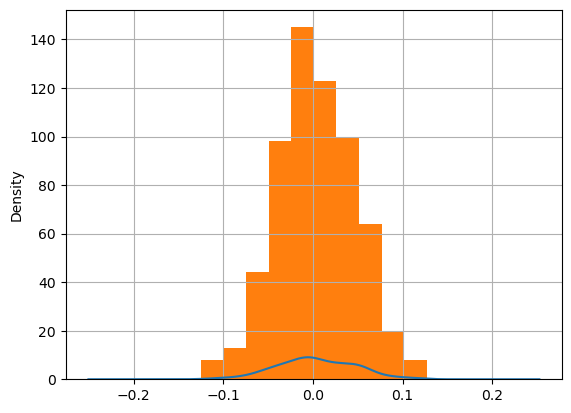

In [185]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [186]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

1260 623


In [187]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 623/623 [45:28<00:00,  4.38s/it]    


In [188]:
all_betas_ev[0]

,0
0,0.958450
1,2.014653
2,2.241514
3,0.288740
4,1.074275
...,...
1995,1.043550
1996,1.574235
1997,1.804987
1998,0.980533


In [189]:
all_betas_iv[0]

,0
0,0.975098
1,1.890382
2,2.229217
3,0.450839
4,1.029790
...,...
1995,0.986920
1996,1.525126
1997,1.765216
1998,0.954890


### Correlation between iv_errors and ev_errors

In [190]:
h = np.random.randint(0,periods)
print(h)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
np.cov(beta_err_ev.flatten(), beta_err_iv.flatten())[0,1]

591


8.625003017715285e-05

In [191]:
h = np.random.randint(0,periods)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
np.cov(beta_err_ev.flatten(), beta_err_iv.flatten())[0,1]

8.482172283759082e-05

In [192]:
corr_errs = []
for i in range(periods):
    beta_err_ev = all_betas_ev[i].values - sim_betas.T.values
    beta_err_iv = all_betas_iv[i].values - sim_betas.T.values
    corr = stats.pearsonr(beta_err_ev.flatten(), beta_err_iv.flatten())
    corr_errs.append(corr)
print(pd.DataFrame(corr_errs).mean())

0    0.008561
1    0.276930
dtype: float64


In [193]:
pd.DataFrame(corr_errs).describe()

,0,1
count,623.000000,623.000000
mean,0.008561,0.276930
std,0.038166,0.272639
min,-0.088672,0.000002
25%,-0.018600,0.042790
50%,0.015983,0.181635
75%,0.034822,0.458301
max,0.105222,0.999980


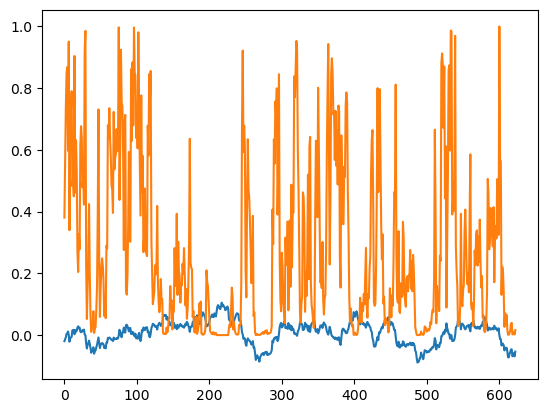

In [194]:
plt.plot(corr_errs)
plt.show()

In [195]:
## Calculating the estimated lambdas

In [196]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

623 60


In [197]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 623/623 [00:04<00:00, 133.03it/s]


In [198]:
# Use the IV estimator equation to calculate lambdas

In [199]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,613,614,615,616,617,618,619,620,621,622
0,0.001990,-0.008279,-0.009626,0.012523,0.014171,-0.003044,-0.002656,-0.009781,0.001763,0.016819,...,0.005570,-0.005872,-0.004093,0.004054,-0.015332,-0.004065,0.007124,0.001889,-0.001846,-0.002270
1,0.176278,-0.073346,-0.215114,-0.211062,0.099518,0.034236,0.126675,-0.004180,-0.084804,0.056084,...,0.045123,0.018371,0.133142,-0.048687,-0.198050,-0.095010,0.081251,-0.159456,-0.095836,0.016963
2,0.053267,-0.021198,-0.029271,-0.023766,0.058130,0.005077,0.028502,0.033976,0.016644,0.003258,...,0.026822,-0.022656,0.018429,-0.012851,0.036757,0.002285,-0.008048,-0.056458,0.024617,0.040940
3,0.094044,-0.146031,0.040490,0.132331,-0.086725,-0.066283,-0.004637,-0.023859,0.011579,0.004546,...,-0.206806,-0.130433,-0.015536,0.096596,-0.060495,0.010334,0.002805,-0.006698,-0.063420,0.049014
4,0.050843,-0.030601,0.012078,-0.035460,-0.005605,0.046709,-0.046834,0.013432,-0.027252,0.015597,...,-0.009874,-0.055002,-0.054889,-0.049195,0.040204,0.041552,-0.015524,-0.057970,0.011509,0.000540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.029053,-0.054781,-0.057074,0.032595,-0.005605,-0.014381,0.027756,0.319010,-0.009680,-0.036135,...,0.038436,-0.113756,-0.040679,-0.181091,-0.095046,0.021379,-0.183177,-0.056312,0.074361,-0.071331
1996,-0.103011,0.075022,0.020717,0.066355,-0.074570,-0.014207,0.068090,0.125367,-0.021673,-0.258625,...,0.132578,-0.047947,-0.019476,0.002199,-0.080141,-0.039318,-0.010832,0.116582,0.092178,0.073555
1997,-0.008692,-0.006650,0.002575,0.029454,-0.007228,-0.006516,-0.004276,0.008227,-0.014945,-0.013978,...,0.017321,0.005517,0.034634,0.009045,-0.017756,-0.025113,-0.023323,-0.006510,0.006474,0.015486
1998,-0.024202,0.011233,-0.008948,-0.029332,0.009223,0.018687,-0.016201,0.009710,0.023968,-0.008309,...,0.007563,-0.028459,0.032099,-0.003248,0.003055,-0.006740,0.022031,-0.006866,0.009371,-0.005002


In [200]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

9.485289760698223e-18 IV is Exogenous


In [201]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.000761192063376078 EV is Endogenous


In [202]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [203]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.9795027125668954 IV is Strong


In [204]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [205]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.9897489683329856 36598.34768787844


In [206]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.000855,-0.049048
1,0.004240,0.024754
2,0.000321,0.002261
3,0.000710,-0.028843
4,0.001322,0.057780
...,...,...
618,0.004019,0.035010
619,0.000057,0.042105
620,-0.000186,0.009922
621,0.001169,-0.047673


In [207]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([-0.17983941,  2.17375469]), pvalue=array([0.85733721, 0.03010001]))

In [208]:
all_lambdas_IV[0].describe()

,0,1
count,623.000000,623.000000
mean,-0.000027,0.003823
std,0.003804,0.043893
min,-0.010433,-0.126027
25%,-0.002596,-0.026295
50%,-0.000153,0.001198
75%,0.002716,0.036047
max,0.013520,0.129387


In [209]:
print(np.mean(mean_MKT*21), np.mean(all_lambdas_IV[0].iloc[:,1]))

0.004833333333333333 0.0038226600104745837


In [210]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - mean_MKT*21)/(mean_MKT*21)*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -20.910482541905154
ex-post bias(%): -17.703884201041557
